In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import pathlib
import glob
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to disable all debugging logs

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
# Make a working direciry for potator data
!mkdir ./Potato_Dataset

In [4]:
# setting up the dataset to be used by tf.keras.preprocessing.image_dataset_from_directory

!cp -rf ../input/plant-village/PlantVillage/Potato___healthy ./Potato_Dataset/Potato___healthy
!cp -rf ../input/plant-village/PlantVillage/Potato___Early_blight ./Potato_Dataset/Potato___Early_blight
!cp -rf ../input/plant-village/PlantVillage/Potato___Late_blight ./Potato_Dataset/Potato___Late_blight

In [5]:
potato_dir =  os.listdir('./Potato_Dataset')
for filenames in potato_dir:
    print(filenames)

Potato___healthy
Potato___Early_blight
Potato___Late_blight


In [6]:
# Global initialization of some imp variables
Image_Size = 256
Batch_Size = 32
Channels = 3
Epochs = 40
potato_datadir = pathlib.Path('./Potato_Dataset')

In [7]:
# yields batches of images from the subdirectories class_a , class_b and class_c 
# together with labels 0 , 1 and 2 (0, 1, 2 corresponding to classes class_a , class_b and class_c respectively )
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    potato_datadir,
    batch_size = Batch_Size, 
    image_size = (Image_Size, Image_Size), 
    shuffle = True)

Found 2152 files belonging to 3 classes.


In [8]:
# Folders(classes) in 'Dataset' directory
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
# Determine Number of Batches beased on the Batch size
# Number of Batches = (total number of files belonging to all classes / Batch_Size)
# This is the number retruned in dataset above.
len(dataset) 

68

In [10]:
print(dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


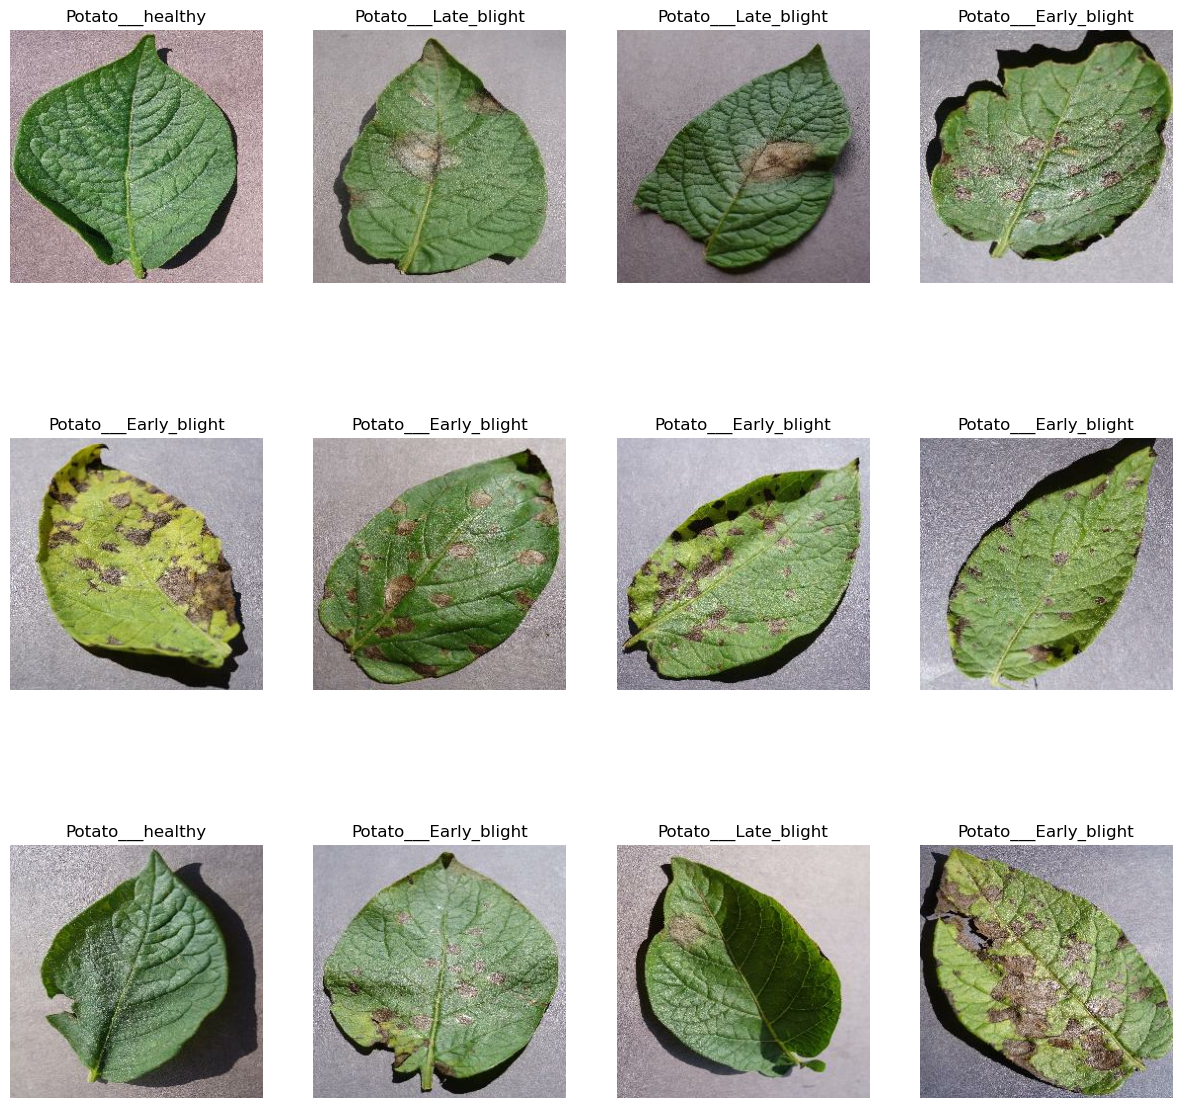

In [11]:
# Plot some of the images
plt.figure(figsize=(15,15))
# dataset.take(count) : Creates a Dataset with at most 'count' elements(batch) from the dataset
for img, label in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        #converting all data of image into numpy and than to intiger type as they were in float.
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(class_name[label[i]])
        plt.axis('off')

In [12]:
# function to split the dataset for train, validation, test
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, 
                  shuffle=True, shuffle_size=10000):
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=10)
    
    ds_size = len(ds)
    train_size = int(len(ds) * train_split)
    val_size = int(len(ds) * val_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
    

In [13]:
train_data, val_data, test_data = split_dataset(dataset)

In [14]:
print("Total Batch Size of Data is :{0} \nBatch size of Training Data is :{1}\n\
Batch size of Validation Data is :{2} \n\
Batch size of Testing Data is :{3} " .format(len(dataset), 
len(train_data), len(val_data), len(test_data)))

Total Batch Size of Data is :68 
Batch size of Training Data is :54
Batch size of Validation Data is :6 
Batch size of Testing Data is :8 


In [15]:
# Cache,Shuffle & Prefetch Data
train_data = train_data.cache().shuffle(100).prefetch(tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(100).prefetch(tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(100).prefetch(tf.data.AUTOTUNE)

## Process the data

In [16]:
# Image Processing: Rescaling and Resizing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size, Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [17]:
# We don't have enough data, so we will augment our data by flipping some and
# rotating some
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(factor=0.5)
])

### Building the Model

In [18]:
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
num_classes = 3 # Healthy, Early_Blight, Late_Blight
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [20]:
# Optimizing the model 'SparseCategoricalCrossentropy'=>as there are many categorical classes of data
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
# Fit the model with training data and pass validation
history = model.fit(train_data,
                   epochs=Epochs,
                   batch_size=Batch_Size,
                   verbose=1,
                   validation_data=val_data
                   )

Epoch 1/40
54/54 [==============================] - 23s 126ms/step - loss: 0.9172 - accuracy: 0.4595 - val_loss: 0.8420 - val_accuracy: 0.4740
Epoch 2/40
54/54 [==============================] - 3s 63ms/step - loss: 0.6844 - accuracy: 0.6450 - val_loss: 0.5836 - val_accuracy: 0.7083
Epoch 3/40
54/54 [==============================] - 3s 62ms/step - loss: 0.5043 - accuracy: 0.7717 - val_loss: 0.4899 - val_accuracy: 0.7760
Epoch 4/40
54/54 [==============================] - 3s 62ms/step - loss: 0.3738 - accuracy: 0.8462 - val_loss: 0.6186 - val_accuracy: 0.7708
Epoch 5/40
54/54 [==============================] - 3s 62ms/step - loss: 0.3104 - accuracy: 0.8715 - val_loss: 0.3918 - val_accuracy: 0.8281
Epoch 6/40
54/54 [==============================] - 3s 62ms/step - loss: 0.2492 - accuracy: 0.9008 - val_loss: 0.2731 - val_accuracy: 0.8906
Epoch 7/40
54/54 [==============================] - 3s 64ms/step - loss: 0.1904 - accuracy: 0.9313 - val_loss: 0.3560 - val_accuracy: 0.8438
Epoch 8/40


In [22]:
scores = model.evaluate(test_data)

8/8 [==============================] - 3s 29ms/step - loss: 0.1123 - accuracy: 0.9609


## Analyse the outcome

In [23]:
# collect model data
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']


Text(0.5, 1.0, 'Training & Validation Loss')

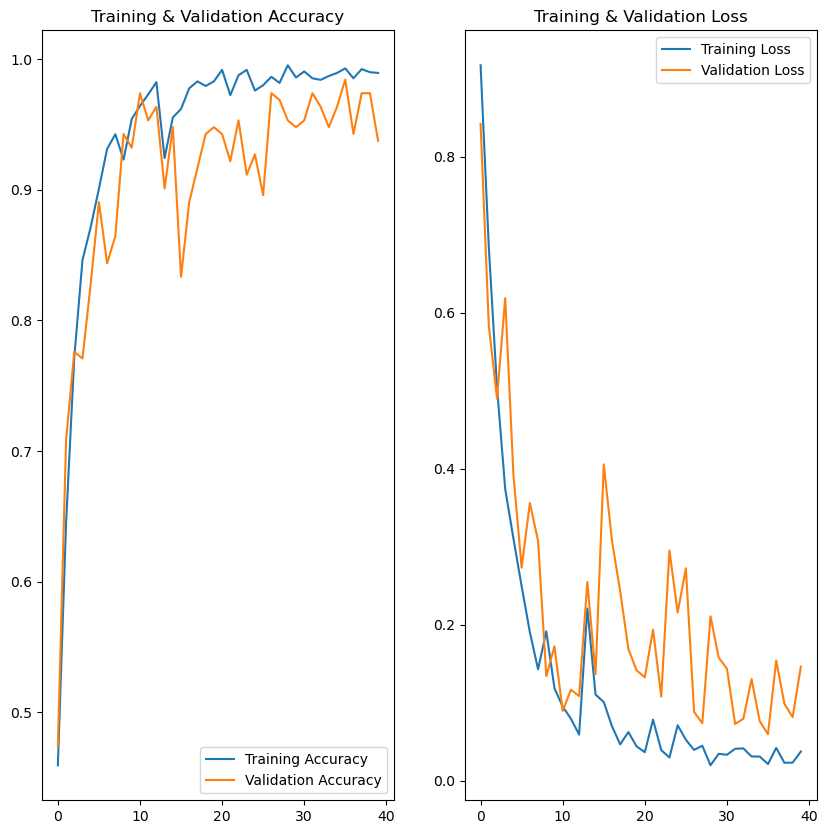

In [24]:
# plot model data
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(Epochs), train_accuracy, label='Training Accuracy')
plt.plot(range(Epochs), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(Epochs), train_loss, label='Training Loss')
plt.plot(range(Epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training & Validation Loss')

Actual Label:  Potato___Late_blight
1/1 [==============================] - 0s 181ms/step
predicted Label:  Potato___Late_blight


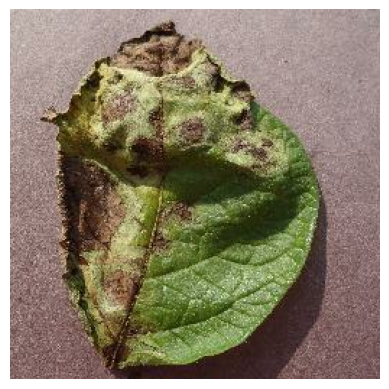

In [25]:
# Test the model on a single test image
# Recall: batch_image will hold 32 images eac time.
for batch_image, batch_label in test_data.take(1):
    image = batch_image[0].numpy().astype('uint8')
    label = class_name[batch_label[0]]
    
    plt.imshow(image)
    print('Actual Label: ', label)
    
    # Now see the prediction
    # Note: This model is based n batches of 32 images each, therefore
    #       Prediction is done on batches of 32 iamges each time.
    #       In the line below, we are predicing the first batch of test images
    #       then taking the first image in the batch to evluate.
    pred = model.predict(batch_image)
    
    # Note: pred[0] will hold 3 probabilities for this image = num_classes (see model definition)
    #       The maximum probability is the one being predicted for this image.
    #       Since pred[0] is a list like [40%, 90%, 60%], np.argmax() will return the index where max occurs.
    print('predicted Label: ', class_name[np.argmax(pred[0])])
    plt.axis('off')

1/1 [==============================] - 0s 34ms/step


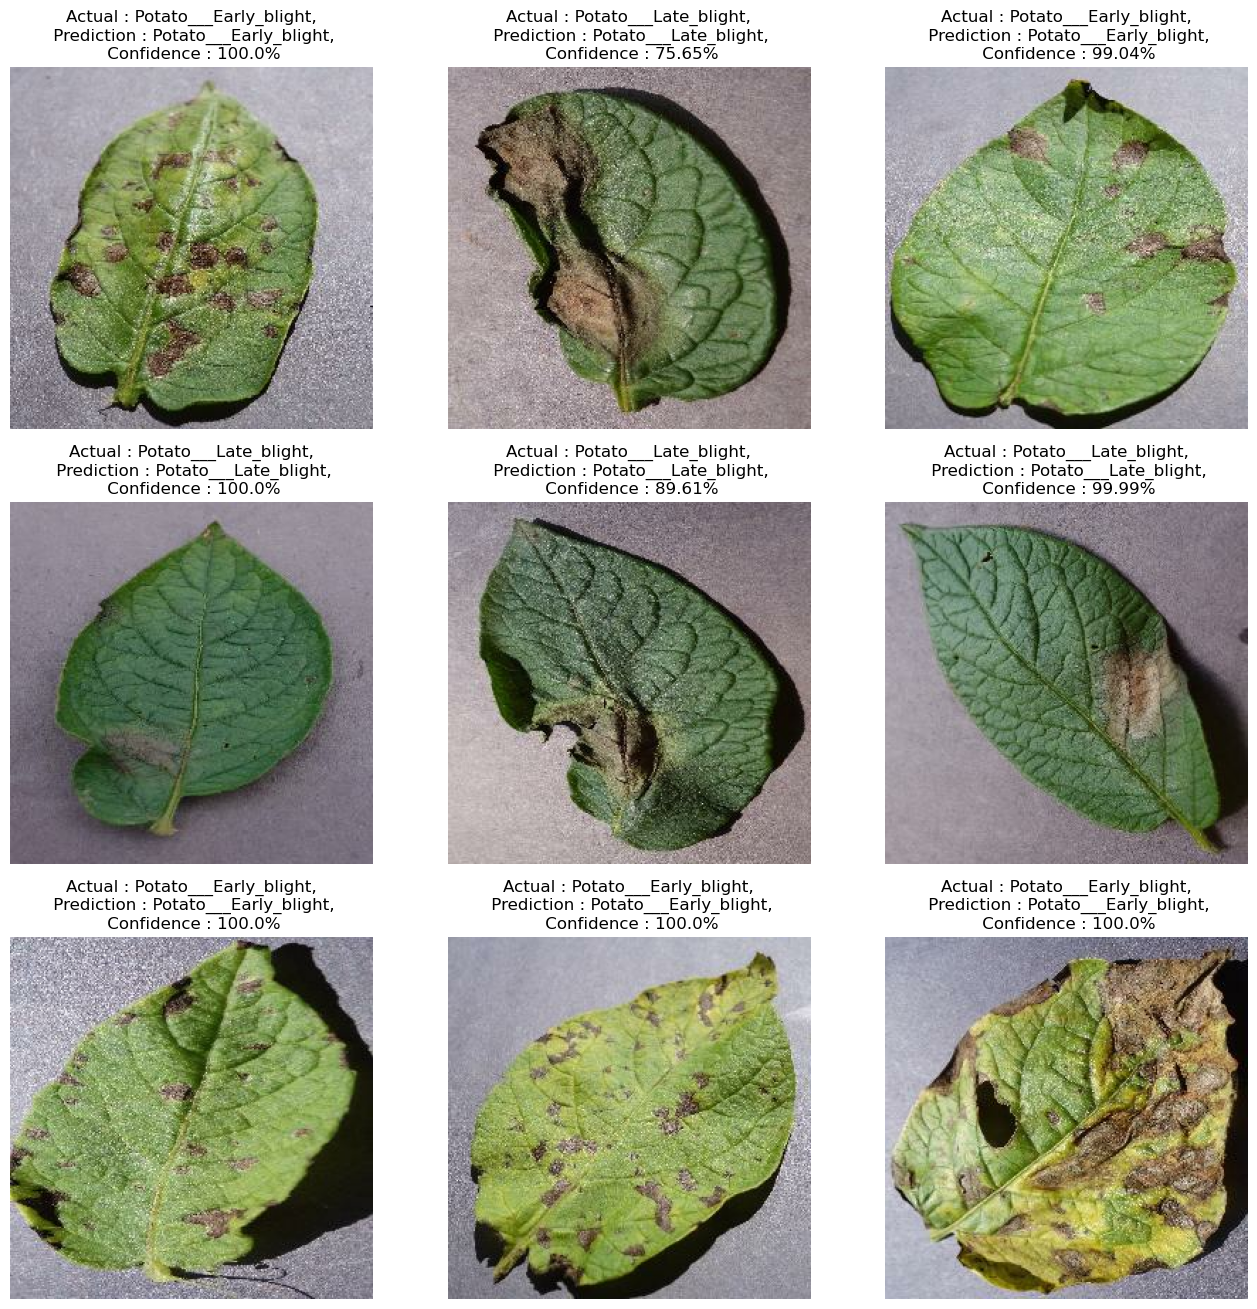

In [26]:
# plotting batch of images with its actual label, predicted label and confidence from Test Data
plt.figure(figsize = (16,16))
for batch_image, batch_label in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        image = batch_image[i].numpy().astype('uint8')
        label = class_name[batch_label[i]]
    
        plt.imshow(image)
    
        batch_prediction = model.predict(batch_image)
        predicted_class = class_name[np.argmax(batch_prediction[i])]
        confidence = round(np.max(batch_prediction[i]) * 100, 2)
        
        plt.title(f'Actual : {label},\n Prediction : {predicted_class},\n Confidence : {confidence}%')
    
        plt.axis('off')

## Sve the complete model. Not just weights

In [27]:
model.save('./Potato-Blight-Model-v1.keras')

### Defne a helper function to predict a single image using this model

In [32]:
# recall that the model here is built to work with batches of 32 images.
# Therfore each time a call is make to model.predict(), a 32-element array 
# is returned, as in the "predictions" list below.
def predict(model, img):
    
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    
    # this call will make sure the image has an additional dimension added
    # to its first index (the axis=0). This will effectively make the shape
    # (1, 256, 256, 3). The tf.expand_dims() will add an extra dimension to 
    # the first axis (column).
    img_array = tf.expand_dims(img, axis=0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 21ms/step


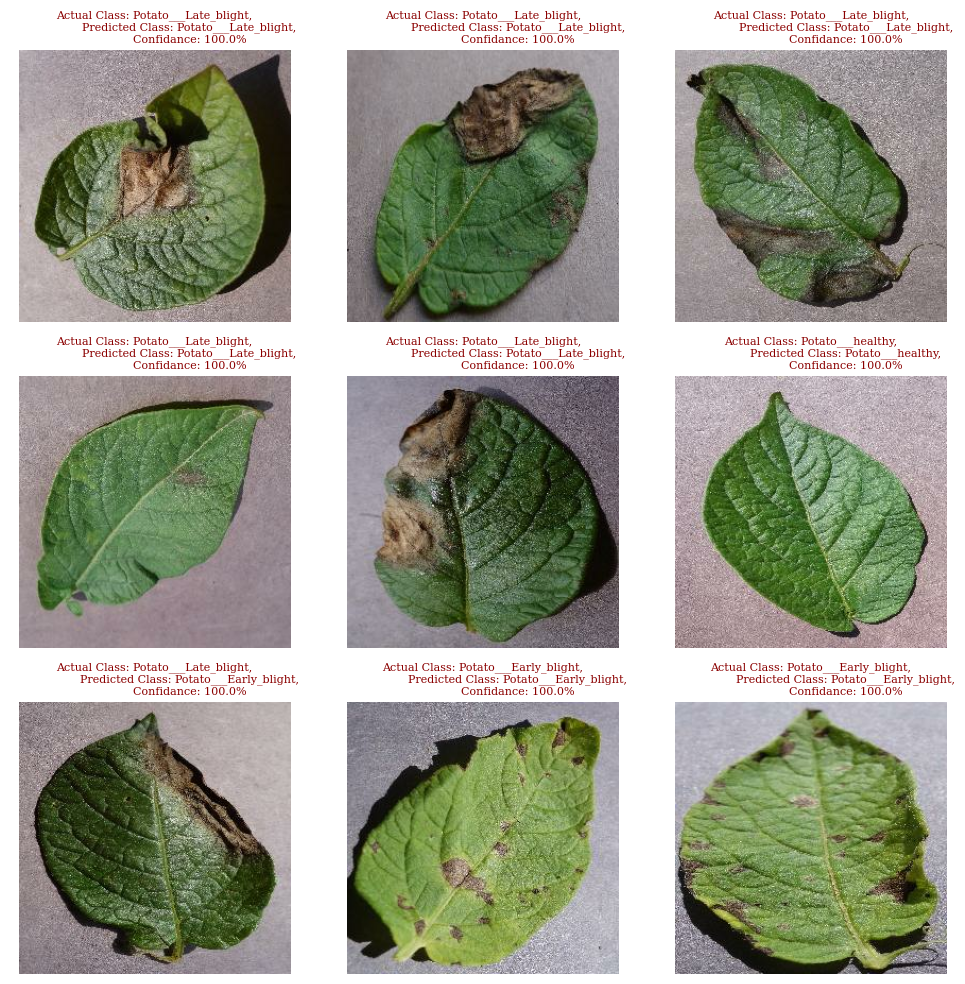

In [41]:
# Let's test the "predict" function with a few images
plt.figure(figsize=(12,12))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        pred_class, Confidance = predict(model, images[i])
        actual_class = class_name[labels[i]]
        
        font = {'family':'serif','color':'darkred','size':8}
        plt.title(f"Actual Class: {actual_class},\n\
                    Predicted Class: {pred_class},\n\
                    Confidance: {confidence}%", fontdict=font
                 )
        plt.axis('off')